In [1]:
import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import os.path

from os import getcwd
import numpy as np
import pandas as pd
import hdf5storage
import h5py
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.io import savemat, loadmat
import math
from scipy.fftpack import fft, ifft
from scipy.stats import zscore, f_oneway
#import samplerate
import multiprocessing as mp
from scipy.signal import resample
import random
import pyreadr
from scipy import stats
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import LeaveOneOut
from sklearn.metrics import r2_score
import statsmodels.api as sm
import scipy
import matplotlib.patches as mpatches
import statsmodels.stats.multitest as multitest
import mne
from mne.preprocessing import ICA
from mne.time_frequency import tfr_morlet
from sklearn.metrics import r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
mer_loc = pd.read_csv('mer_loc.csv', index_col=0)
mer_loc

,SubjectID,session,electrode,unit_id,unit,RecType,grade,Native_X,Native_Y,Native_Z,MNI_X,MNI_Y,MNI_Z,position,Depth,Side
0,DBS3001,1,micro_m,6,4,MU,B,-13.020185,-18.789530,14.821099,-12.880210,-13.270645,-5.188665,m,1.296,left
1,DBS3001,2,micro_c,7,1,MU,C,-14.373328,-19.327820,13.194792,-14.173885,-14.049870,-6.999482,c,0.421,left
2,DBS3001,2,micro_p,8,1,MU,C,-14.573305,-21.161406,13.968077,-14.323757,-15.719308,-5.542893,p,0.421,left
3,DBS3001,2,micro_m,10,2,MU,C,-12.613638,-19.127842,14.124040,-12.525224,-13.722380,-6.055707,m,0.421,left
4,DBS3001,2,micro_m,11,3,SU,B,-12.613638,-19.127842,14.124040,-12.525224,-13.722380,-6.055707,m,0.421,left
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
224,DBS3032,2,micro_c,4,1,MU,C,-12.321505,-15.500814,3.310374,-12.531485,-13.027212,-7.741866,c,0.910,left
225,DBS3032,2,micro_c,6,3,MU,B,-12.321505,-15.500814,3.310374,-12.531485,-13.027212,-7.741866,c,0.910,left
226,DBS3032,3,micro_c,10,2,MU,B,-12.022031,-16.169508,2.225641,-12.185466,-13.727605,-8.998178,c,-0.399,left
227,DBS3032,3,micro_p,11,1,MU,C,-12.149851,-17.884098,3.247328,-12.229430,-15.471691,-7.700987,p,-0.399,left


In [3]:
cue_unit = pd.read_csv('cue_unit.csv', index_col=0)
cue_unit.head()
cue_unit.shape

,SubjectID,Good?,Cue,Cue dir,Cue how,Speech,Speech dir,Speech how,Unnamed: 9,session,electrode,unit_id,unit,RecType,grade
0,DBS3001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,micro_m,6,4,MU,B
1,DBS3001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,micro_c,7,1,MU,C
2,DBS3001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,micro_p,8,1,MU,C
3,DBS3001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,micro_m,10,2,MU,C
4,DBS3001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2,micro_m,11,3,SU,B


(229, 15)

In [4]:
cue_pos = []
cue_neg = []
cue_mixed = []
speech_pos = []
speech_neg = []
speech_mixed = []

for item in range(cue_unit.shape[0]):
    if cue_unit.iloc[item, 2] == "After":
        if cue_unit.iloc[item, 3] == "+":
            cue_pos.append(item)
        elif cue_unit.iloc[item, 3] == "-":
            cue_neg.append(item)
        elif cue_unit.iloc[item, 3] == "Mixed":
            cue_mixed.append(item)
    if cue_unit.iloc[item, 5] == "Before":
        if cue_unit.iloc[item, 6] == "+":
            speech_pos.append(item)
        elif cue_unit.iloc[item, 6] == "-":
            speech_neg.append(item)
        elif cue_unit.iloc[item, 6] == "Mixed":
            speech_mixed.append(item)
            
cue_pos = mer_loc.iloc[cue_pos]
cue_neg = mer_loc.iloc[cue_neg]
cue_mixed = mer_loc.iloc[cue_mixed]
speech_pos = mer_loc.iloc[speech_pos]
speech_neg = mer_loc.iloc[speech_neg]
speech_mixed = mer_loc.iloc[speech_mixed]

In [5]:
cue_only = []
cue_speech = []
for item in range(cue_unit.shape[0]):
    if cue_unit.iloc[item, 2] == "After":
        if cue_unit.iloc[item, 5] == "Before":
            cue_speech.append(item)
        elif cue_unit.iloc[item, 5] == "After":
            cue_speech.append(item)
        else:
            cue_only.append(item)
            
cue_only = mer_loc.iloc[cue_only]
cue_speech = mer_loc.iloc[cue_speech]
cue_any = pd.concat([cue_only, cue_speech])

In [6]:
mer_loc_cue_only = mer_loc.iloc[cue_only.index]
mer_loc_cue_speech = mer_loc.iloc[cue_speech.index]
mer_loc_cue_pos = mer_loc.iloc[cue_pos.index]
mer_loc_cue_neg = mer_loc.iloc[cue_neg.index]

In [7]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), 50)]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        
rand_x_mean = np.array(rand_x_mean)
rand_y_mean = np.array(rand_y_mean)
rand_z_mean = np.array(rand_z_mean)
rand_x_sd = np.array(rand_x_sd)
rand_y_sd = np.array(rand_y_sd)
rand_z_sd = np.array(rand_z_sd)
rand_all_sd = np.array(rand_all_sd)


In [8]:
deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2

sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)


In [9]:
len(mer_loc_cue_only)

24

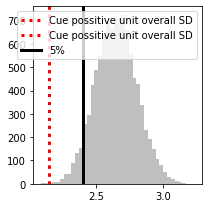

In [10]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3), tight_layout=1)


axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
axs.axvline(sd_trial_cue, color='r', linewidth=3, label='Cue possitive unit overall SD', linestyle='dotted')
axs.axvline(sd_trial_cue, color='r', linewidth=3, label='Cue possitive unit overall SD', linestyle='dotted')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.05)], color='k', linewidth=3, label='5%')
axs.legend()

plt.show();

In [11]:
len(mer_loc_cue_only)
len(mer_loc_cue_speech)
n_cue = len(mer_loc_cue_only) + len(mer_loc_cue_speech)


24

66

In [12]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), n_cue)]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        
rand_x_mean = np.array(rand_x_mean)
rand_y_mean = np.array(rand_y_mean)
rand_z_mean = np.array(rand_z_mean)
rand_x_sd = np.array(rand_x_sd)
rand_y_sd = np.array(rand_y_sd)
rand_z_sd = np.array(rand_z_sd)
rand_all_sd = np.array(rand_all_sd)


In [13]:
deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2

sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)


In [22]:
mer_loc_cue_only.index.shape[0]

24

In [27]:
mer_loc_cue_only.index.shape[0]
mer_loc_cue_speech.index.shape[0]

24

66

In [25]:
num_elec = mer_loc_cue_only.index.shape[0] + mer_loc_cue_speech.index.shape[0]

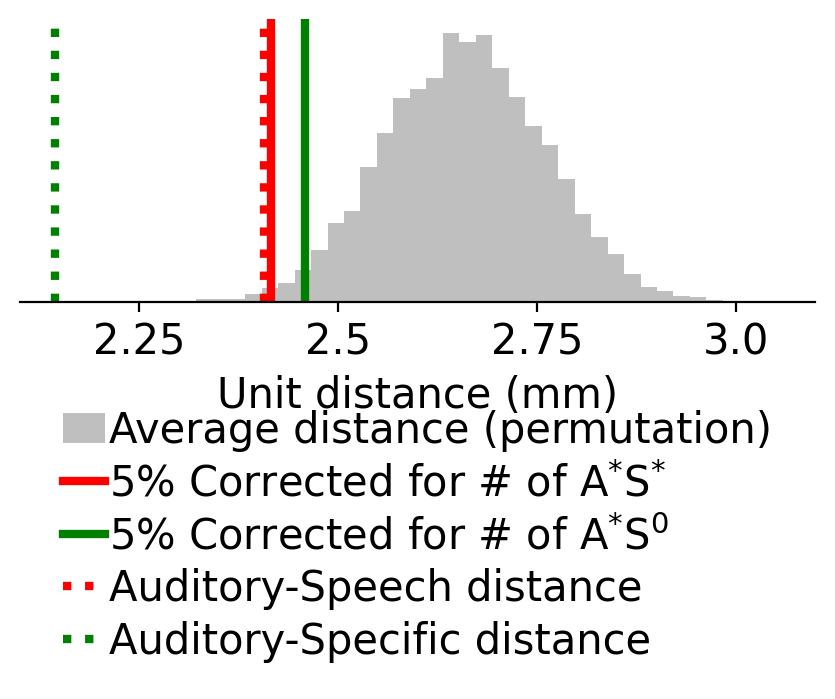

In [37]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 4), tight_layout=1, dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40, label='Average distance (permutation)')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.5/mer_loc_cue_speech.index.shape[0])], 
            color='r', linewidth=3, label='5% Corrected for # of A$^{*}$S$^{*}$')
axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.5/mer_loc_cue_only.index.shape[0])], 
            color='g', linewidth=3, label='5% Corrected for # of A$^{*}$S$^{0}$')
#axs.axvline(np.sort(rand_all_sd)[int(rand_all_sd.shape[0]*0.975)], color='k', linewidth=3)




deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='r', linewidth=3, label='Auditory-Speech distance', linestyle='dotted')




deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='g', linewidth=3, label='Auditory-Specific distance', linestyle='dotted')

axs.set_xlabel('Unit distance (mm)', fontsize=15)
axs.set_yticks([])
axs.set_xticks(np.linspace(2.25, 3.25, 5))
axs.set_xticklabels(np.linspace(2.25, 3.25, 5), fontsize=15)
plt.legend(fontsize=15, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.25), 
           handletextpad=0.1, handlelength=1, labelspacing=0.25)

sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xlim(2.1, 3.1)

plt.show();

Text(0.5, 1.0, 'E=mc$^{2}$c$^{2}$')

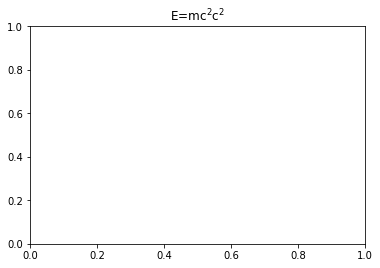

In [36]:
plt.title("E=mc$^{2}$c$^{2}$")
plt.show()

In [38]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), len(mer_loc_cue_only))]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        
rand_x_mean_a = np.array(rand_x_mean)
rand_y_mean_a = np.array(rand_y_mean)
rand_z_mean_a = np.array(rand_z_mean)
rand_x_sd_a = np.array(rand_x_sd)
rand_y_sd_a = np.array(rand_y_sd)
rand_z_sd_a = np.array(rand_z_sd)
rand_all_sd_a = np.array(rand_all_sd)


In [39]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), len(mer_loc_cue_speech))]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += np.sqrt(diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = sd_trial / len(diff_x)
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        
rand_x_mean_s = np.array(rand_x_mean)
rand_y_mean_s = np.array(rand_y_mean)
rand_z_mean_s = np.array(rand_z_mean)
rand_x_sd_s = np.array(rand_x_sd)
rand_y_sd_s = np.array(rand_y_sd)
rand_z_sd_s = np.array(rand_z_sd)
rand_all_sd_s = np.array(rand_all_sd)


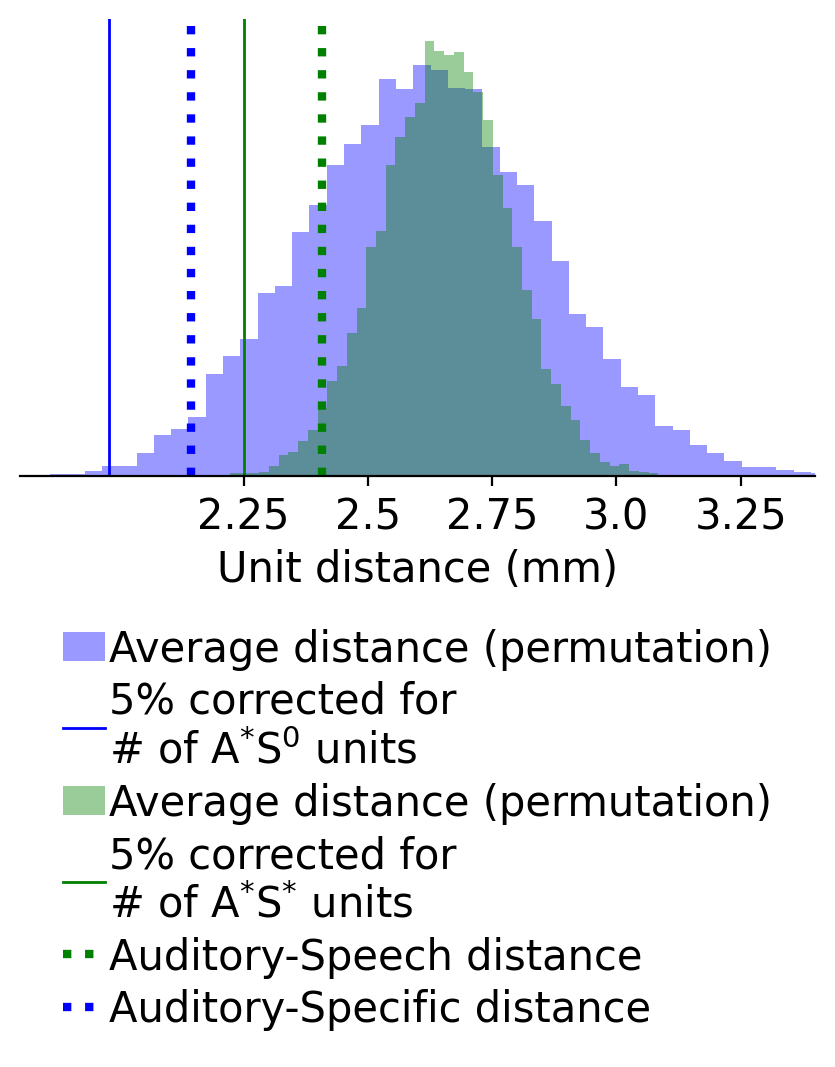

In [44]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 6), tight_layout=1, dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd_a, color='blue', alpha=0.4, bins=50, label='Average distance (permutation)')
axs.axvline(np.sort(rand_all_sd_a)[int(rand_all_sd_a.shape[0]*0.05/mer_loc_cue_only.index.shape[0])], 
            color='blue', linewidth=1, 
            label='5% corrected for \n# of A$^{*}$S$^{0}$ units')


axs.hist(rand_all_sd_s, color='green', alpha=0.4, bins=50, label='Average distance (permutation)')
axs.axvline(np.sort(rand_all_sd_s)[int(rand_all_sd_s.shape[0]*0.05/mer_loc_cue_speech.index.shape[0])], 
            color='green', linewidth=1, 
            label='5% corrected for \n# of A$^{*}$S$^{*}$ units')



deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='green', linewidth=3, label='Auditory-Speech distance', linestyle='dotted')




deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='blue', linewidth=3, label='Auditory-Specific distance', linestyle='dotted')



axs.set_xlabel('Unit distance (mm)', fontsize=15)
axs.set_yticks([])
axs.set_xticks(np.linspace(2.25, 3.25, 5))
axs.set_xticklabels(np.linspace(2.25, 3.25, 5), fontsize=15)
plt.legend(fontsize=15, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.25), 
           handletextpad=0.1, handlelength=1, labelspacing=0.25)

sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xlim(1.8, 3.4)

plt.show();

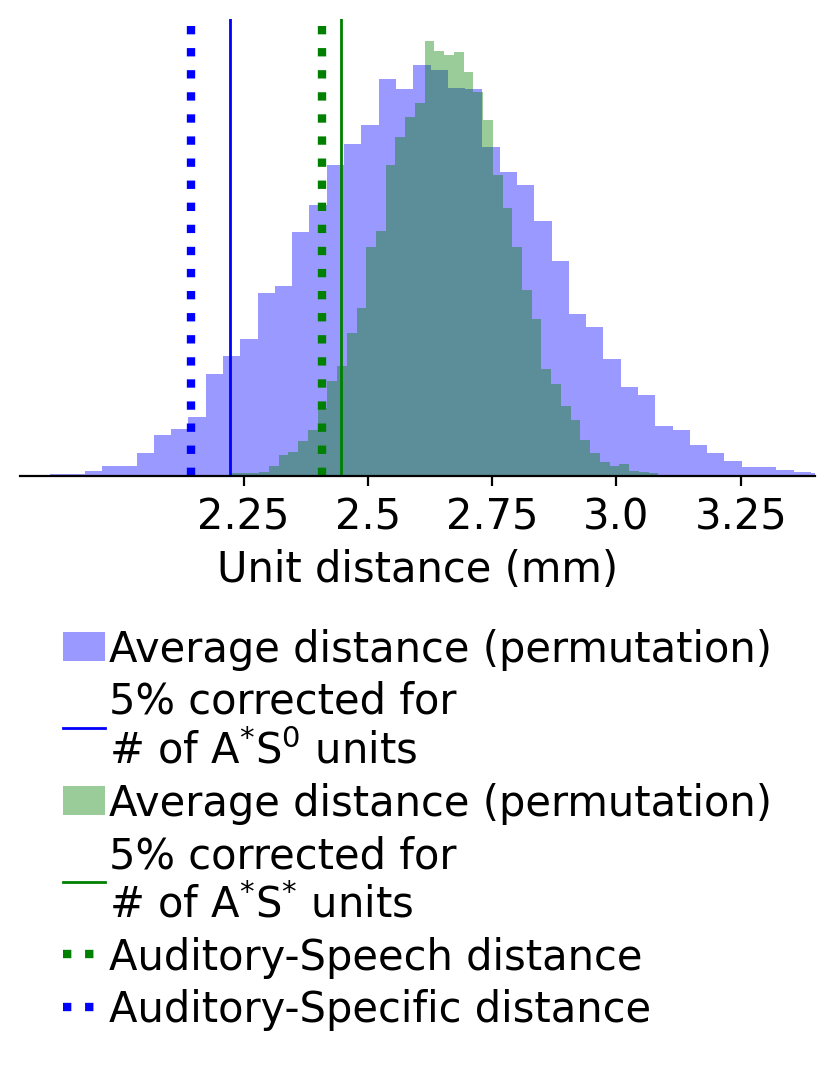

In [45]:
fig, axs = plt.subplots(1, 1, figsize=(4.5, 6), tight_layout=1, dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd_a, color='blue', alpha=0.4, bins=50, label='Average distance (permutation)')
axs.axvline(np.sort(rand_all_sd_a)[int(rand_all_sd_a.shape[0]*0.05)], 
            color='blue', linewidth=1, 
            label='5% corrected for \n# of A$^{*}$S$^{0}$ units')


axs.hist(rand_all_sd_s, color='green', alpha=0.4, bins=50, label='Average distance (permutation)')
axs.axvline(np.sort(rand_all_sd_s)[int(rand_all_sd_s.shape[0]*0.05)], 
            color='green', linewidth=1, 
            label='5% corrected for \n# of A$^{*}$S$^{*}$ units')



deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='green', linewidth=3, label='Auditory-Speech distance', linestyle='dotted')




deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='blue', linewidth=3, label='Auditory-Specific distance', linestyle='dotted')



axs.set_xlabel('Unit distance (mm)', fontsize=15)
axs.set_yticks([])
axs.set_xticks(np.linspace(2.25, 3.25, 5))
axs.set_xticklabels(np.linspace(2.25, 3.25, 5), fontsize=15)
plt.legend(fontsize=15, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.25), 
           handletextpad=0.1, handlelength=1, labelspacing=0.25)

sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xlim(1.8, 3.4)

plt.show();

In [18]:
# a*s0

mean = np.mean(rand_all_sd_a)
std = np.std(rand_all_sd_a)

deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)


z = (sd_trial_cue - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

0.02355267579323956

In [19]:
# a*s*

mean = np.mean(rand_all_sd_s)
std = np.std(rand_all_sd_s)

deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)


z = (sd_trial_cue - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

0.026669072147808438

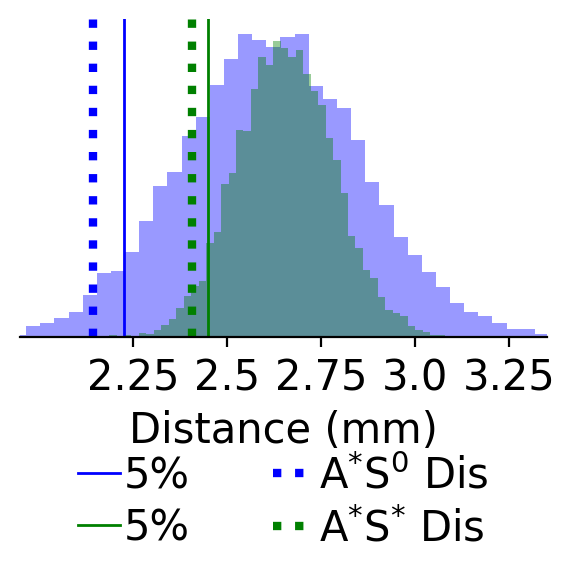

In [17]:
fig, axs = plt.subplots(1, 1, figsize=(3, 3.25), tight_layout=1, dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd_a, color='blue', alpha=0.4, bins=50)
axs.axvline(np.sort(rand_all_sd_a)[int(rand_all_sd_a.shape[0]*0.05)], color='blue', linewidth=1, 
            label='5%')
#axs.axvline(np.sort(rand_all_sd_a)[int(rand_all_sd_a.shape[0]*0.975)], color='blue', linewidth=1)


axs.hist(rand_all_sd_s, color='green', alpha=0.4, bins=50)
axs.axvline(np.sort(rand_all_sd_s)[int(rand_all_sd_s.shape[0]*0.05)], color='green', linewidth=1, 
            label='5%')
#axs.axvline(np.sort(rand_all_sd_s)[int(rand_all_sd_s.shape[0]*0.975)], color='green', linewidth=1)



deff_x_cue = (mer_loc_cue_only['MNI_X'] - mer_loc_cue_only['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_only['MNI_Y'] - mer_loc_cue_only['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_only['MNI_Z'] - mer_loc_cue_only['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_only)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='blue', linewidth=3, label='A$^{*}$S$^{0}$ Dis', linestyle='dotted')


deff_x_cue = (mer_loc_cue_speech['MNI_X'] - mer_loc_cue_speech['MNI_X'].mean()) ** 2
deff_y_cue = (mer_loc_cue_speech['MNI_Y'] - mer_loc_cue_speech['MNI_Y'].mean()) ** 2
deff_z_cue = (mer_loc_cue_speech['MNI_Z'] - mer_loc_cue_speech['MNI_Z'].mean()) ** 2
sd_trial_cue = 0
for item in range(len(mer_loc_cue_speech)):
    sd_trial_cue += np.sqrt(deff_x_cue.iloc[item] + deff_y_cue.iloc[item] + deff_z_cue.iloc[item])
sd_trial_cue = sd_trial_cue / len(deff_x_cue)
axs.axvline(sd_trial_cue, color='green', linewidth=3, label='A$^{*}$S$^{*}$ Dis', linestyle='dotted')

axs.set_xlabel('Distance (mm)', fontsize=15)
axs.set_yticks([])
axs.set_xticks(np.linspace(2.25, 3.25, 5))
axs.set_xticklabels(np.linspace(2.25, 3.25, 5), fontsize=15, rotation=0)
plt.legend(fontsize=15, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.25), 
           handletextpad=0.1, handlelength=1, labelspacing=0.25, ncol=2)

sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
axs.set_xlim(1.95, 3.35)

plt.show();

Text(0.5, 1.0, 'Title with superscript: x$^{2}$')

Text(0.5, 0, 'X-axis label with superscript: x$^{1}$')

Text(0, 0.5, 'Y-axis label with superscript: y$^{3}$')

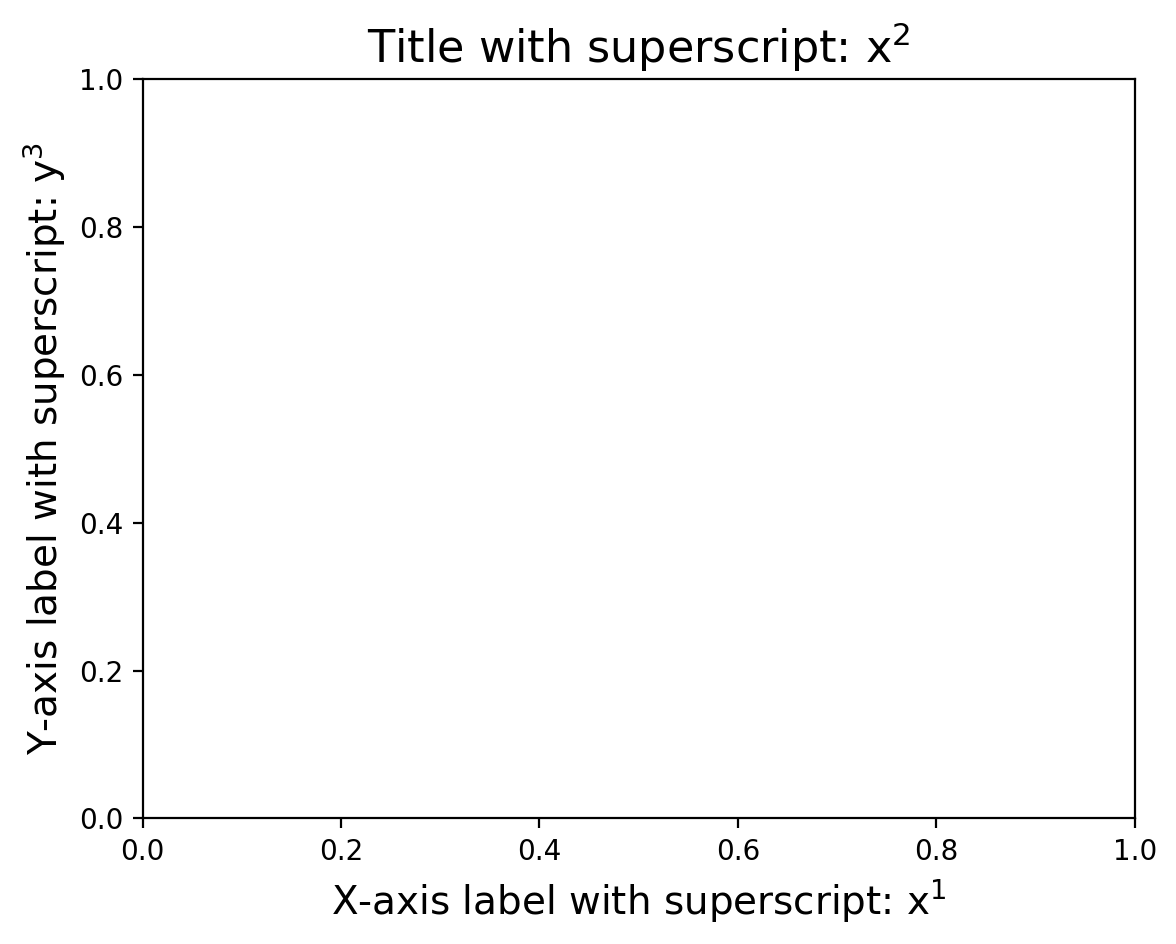

In [41]:

# Create a plot
fig, ax = plt.subplots()

# Set title or labels with superscript using LaTeX-style formatting
ax.set_title("Title with superscript: x$^{2}$", fontsize=16)
ax.set_xlabel("X-axis label with superscript: x$^{1}$", fontsize=14)
ax.set_ylabel("Y-axis label with superscript: y$^{3}$", fontsize=14)

# Display the plot
plt.show()

In [23]:
len(mer_loc)

229

In [46]:
sig_diff_c = np.array([28, 48, 122, 174, 176, 184, 185, 189, 199])

sig_diff_v = np.array([30, 129, 168, 176, 199, 226])

sig_diff_id = np.array([24, 26, 27, 28, 48, 59, 62, 66, 67, 69, 74, 84, 106, 112, 
                        114, 119, 122, 145, 147, 148, 152, 154, 171, 172, 174, 175, 
                        184, 185, 187, 189, 199, 203, 213, 215, 216, 218])


cue_unit_c = mer_loc.iloc[sig_diff_c]
cue_unit_v = mer_loc.iloc[sig_diff_v]
cue_unit_id = mer_loc.iloc[sig_diff_id]

In [47]:
n_cue_unit_c = len(cue_unit_c)
n_cue_unit_v = len(cue_unit_v)
n_cue_unit_cv = n_cue_unit_c + n_cue_unit_v
n_cue_unit_cv

15

In [48]:
len(mer_loc_cue_only)
len(mer_loc_cue_speech)
n_cue = len(mer_loc_cue_only) + len(mer_loc_cue_speech)


24

66

In [49]:
len(rand_all_sd)

10000

In [86]:
# Auditory-C

mean = np.mean(rand_all_sd)
std = np.std(rand_all_sd)
z = (sd_trial_cue_c - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

0.023776844014410846

In [87]:
z

-1.981335265858093

In [55]:
# Auditory-V

mean = np.mean(rand_all_sd)
std = np.std(rand_all_sd)
z = (sd_trial_cue_v - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

1.225881085483459e-08

In [56]:
# Auditory-ID

mean = np.mean(rand_all_sd)
std = np.std(rand_all_sd)
z = (sd_trial_cue_id - mean) / std
p_one_sided_left = stats.norm.cdf(z)            # P(X ≤ value)
p_one_sided_left

0.15971179412314446

In [65]:
range(mer_loc.shape[0])
len(mer_loc_cue_only)

range(0, 229)

24

In [67]:
random.sample()

<bound method Random.sample of <random.Random object at 0x7f79a2037010>>

In [104]:
rand_x_mean = []
rand_y_mean = []
rand_z_mean = []
rand_x_sd = []
rand_y_sd = []
rand_z_sd = []
rand_all_sd = []

for i in range(10000):
    rand_unit = mer_loc.iloc[random.sample(range(mer_loc.shape[0]), 51)]
    rand_x = rand_unit['MNI_X']
    rand_y = rand_unit['MNI_Y']
    rand_z = rand_unit['MNI_Z']

    rand_x_mean.append(rand_x.mean())
    rand_y_mean.append(rand_y.mean())
    rand_z_mean.append(rand_z.mean())

    rand_x_sd.append(np.std(rand_x))
    rand_y_sd.append(np.std(rand_y))
    rand_z_sd.append(np.std(rand_z))
    
    diff_x = (rand_x - rand_x.mean()) ** 2
    diff_y = (rand_y - rand_y.mean()) ** 2
    diff_z = (rand_z - rand_z.mean()) ** 2
    
    sd_trial = 0
    for item in range(len(diff_x)):
        sd_trial += (diff_x.iloc[item] + diff_y.iloc[item] + diff_z.iloc[item])
    sd_trial = np.sqrt(sd_trial) / np.sqrt(len(diff_x))
    rand_all_sd.append(sd_trial)
    
    #for i2 in range(50):
        
rand_x_mean_a = np.array(rand_x_mean)
rand_y_mean_a = np.array(rand_y_mean)
rand_z_mean_a = np.array(rand_z_mean)
rand_x_sd_a = np.array(rand_x_sd)
rand_y_sd_a = np.array(rand_y_sd)
rand_z_sd_a = np.array(rand_z_sd)
rand_all_sd = np.array(rand_all_sd)


In [108]:
num_elec = len(sig_diff_c) + len(sig_diff_v) + len(sig_diff_id)

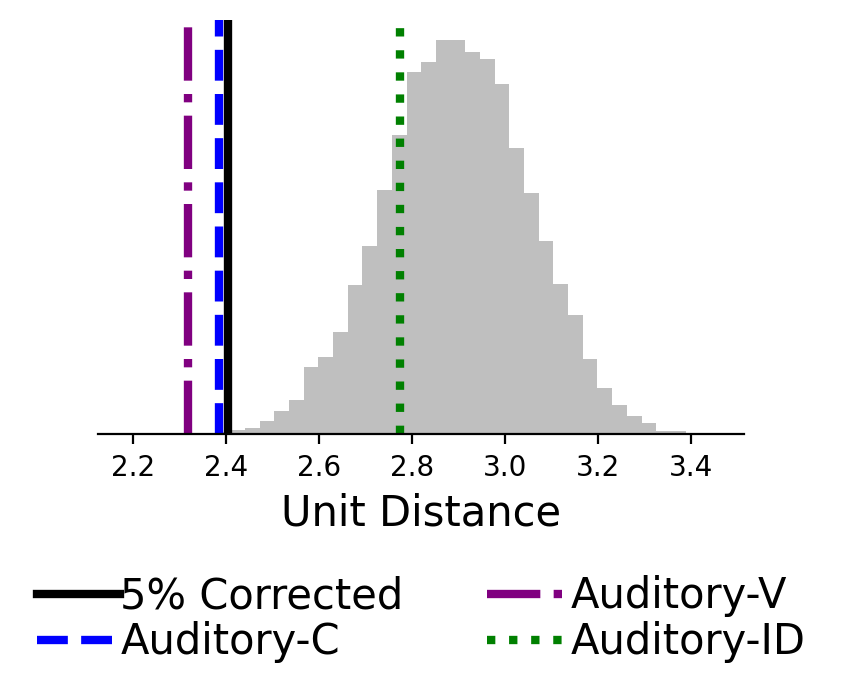

In [110]:
fig, axs = plt.subplots(1, 1, figsize=(4.25, 3.8), tight_layout=1, dpi=200)
fig.patch.set_alpha(0)
axs.patch.set_alpha(0)

axs.hist(rand_all_sd, color='grey', alpha=0.5, bins=40)
#axs.axvline(np.sort(rand_all_sd)[int(len(rand_all_sd)*0.05/6)], color='k', linewidth=3, label='5%')
#axs.axvline(np.sort(rand_all_sd)[int(len(rand_all_sd)*0.05/9)], color='k', linewidth=3, label='5%')
axs.axvline(np.sort(rand_all_sd)[int(len(rand_all_sd)*0.05/num_elec)], color='k', linewidth=3, 
            label='5% Corrected')

#axs.axvline(np.sort(rand_all_sd)[int(len(rand_all_sd)*0.975)], color='k', linewidth=3)

deff_x_cue_c = (cue_unit_c['MNI_X'] - cue_unit_c['MNI_X'].mean()) ** 2
deff_y_cue_c = (cue_unit_c['MNI_Y'] - cue_unit_c['MNI_Y'].mean()) ** 2
deff_z_cue_c = (cue_unit_c['MNI_Z'] - cue_unit_c['MNI_Z'].mean()) ** 2

sd_trial_cue_c = 0
for item in range(len(deff_x_cue_c)):
    sd_trial_cue_c += (deff_x_cue_c.iloc[item] + deff_y_cue_c.iloc[item] + deff_z_cue_c.iloc[item])
sd_trial_cue_c = np.sqrt(sd_trial_cue_c) / np.sqrt(len(deff_x_cue_c))

axs.axvline(sd_trial_cue_c, color='b', linewidth=3, label='Auditory-C', linestyle='dashed')




deff_x_cue_v = (cue_unit_v['MNI_X'] - cue_unit_v['MNI_X'].mean()) ** 2
deff_y_cue_v = (cue_unit_v['MNI_Y'] - cue_unit_v['MNI_Y'].mean()) ** 2
deff_z_cue_v = (cue_unit_v['MNI_Z'] - cue_unit_v['MNI_Z'].mean()) ** 2

sd_trial_cue_v = 0
for item in range(len(deff_x_cue_v)):
    sd_trial_cue_v += (deff_x_cue_v.iloc[item] + deff_y_cue_v.iloc[item] + deff_z_cue_v.iloc[item])
sd_trial_cue_v = np.sqrt(sd_trial_cue_v) / np.sqrt(len(deff_x_cue_v))
axs.axvline(sd_trial_cue_v, color='purple', linewidth=3, label='Auditory-V', linestyle='-.')


deff_x_cue_id = (cue_unit_id['MNI_X'] - cue_unit_id['MNI_X'].mean()) ** 2
deff_y_cue_id = (cue_unit_id['MNI_Y'] - cue_unit_id['MNI_Y'].mean()) ** 2
deff_z_cue_id = (cue_unit_id['MNI_Z'] - cue_unit_id['MNI_Z'].mean()) ** 2

sd_trial_cue_id = 0
for item in range(len(deff_x_cue_id)):
    sd_trial_cue_id += (deff_x_cue_id.iloc[item] + deff_y_cue_id.iloc[item] + deff_z_cue_id.iloc[item])
sd_trial_cue_id = np.sqrt(sd_trial_cue_id) / np.sqrt(len(deff_x_cue_id))
axs.axvline(sd_trial_cue_id, color='g', linewidth=3, label='Auditory-ID', linestyle='dotted')




axs.set_xlabel('Unit Distance', fontsize=15)
axs.set_yticks([])
#axs.set_xticks(np.linspace(2, 3, 5))
#axs.set_xticklabels(np.linspace(2, 3, 5), fontsize=15)
plt.legend(fontsize=15, frameon=False, loc='upper center', bbox_to_anchor=(0.5, -0.25), 
           handletextpad=0.01, handlelength=2, labelspacing=0.1, ncol=2)

sns.despine(ax=axs, top=True, right=True, left=True, bottom=False)
#axs.set_xlim(1.9, 3.1)
plt.show();

In [85]:
sd_trial_cue_c
sd_trial_cue_v
sd_trial_cue_id

2.351032038596415

1.947122746169442

2.5289220996989803

In [78]:
len(sig_diff_c) + len(sig_diff_v) + len(sig_diff_id)

9

6

36